In [371]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
import operator
from skimage.segmentation import clear_border
import torch
import math
from tensorflow.keras.models import load_model
from imutils.perspective import four_point_transform
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
import joblib

(3001, 3000, 3)


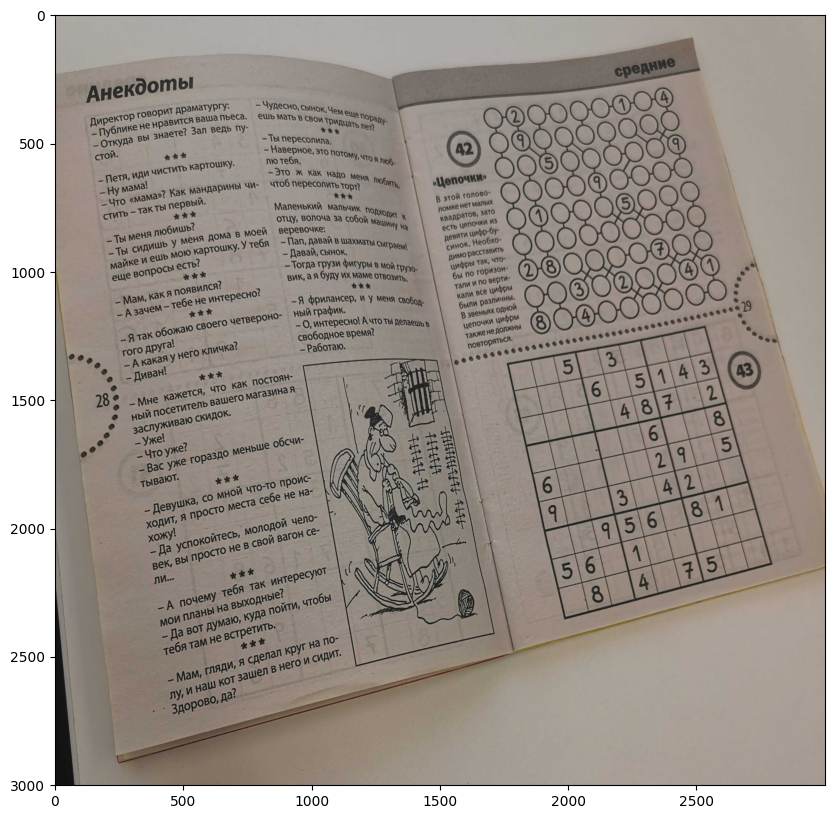

In [289]:
img = cv.imread('train_0.jpg')
#img = cv.imread('train_2.jpg')
imgBGR = cv.cvtColor(img, cv.COLOR_BGR2RGB)

imgGRAY = cv.cvtColor(imgBGR, cv.COLOR_RGB2GRAY)

imgBGR_copy = imgBGR

height, width = 3000, 3000

imgBGR_copy = cv.resize(imgBGR_copy, (width,height))

plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(imgBGR_copy)
print(imgBGR_copy.shape)


In [233]:
imgBlank = np.zeros((450, 450, 3), np.uint8)
# plt.rcParams["figure.figsize"] = (10,10)
# plt.imshow(imgBlank)

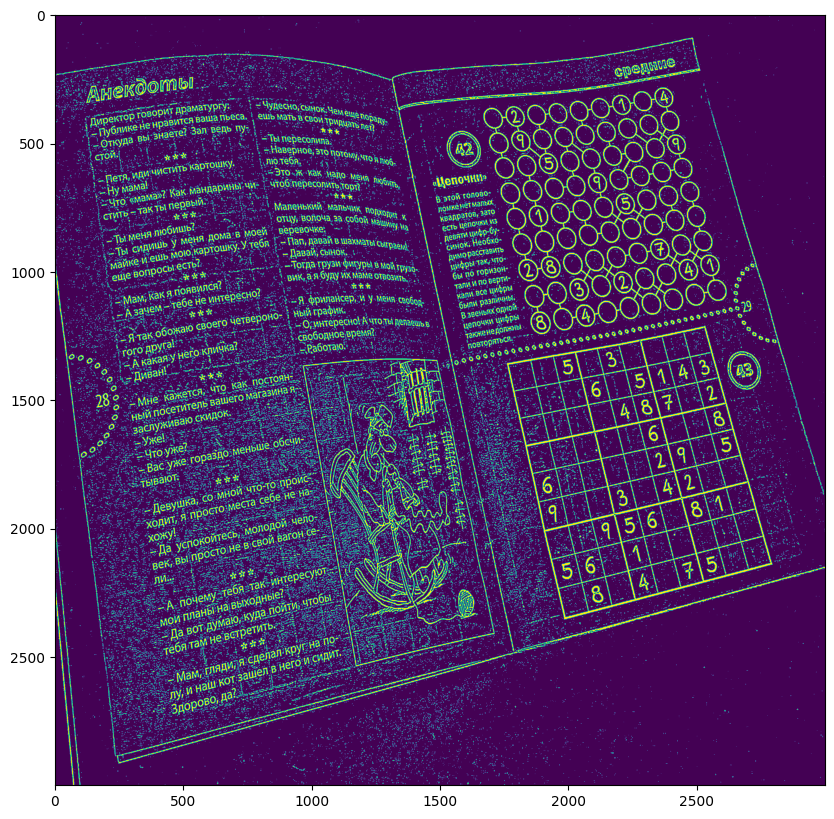

In [213]:
#Img_0 So afterall my adaptive threshold should work everywhere
def preProcess(img):
    imgGray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    imgBlur = cv.GaussianBlur(imgGray, (5,5), 1)
    imgThreshold = cv.adaptiveThreshold(imgBlur, 255, 1, 1, 11, 2)
    # imgThreshold = cv.cvtColor(imgThreshold, cv.COLOR_BGR2RGB)
    return imgThreshold

imgThreshold = preProcess(imgBGR_copy)
plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(imgThreshold)

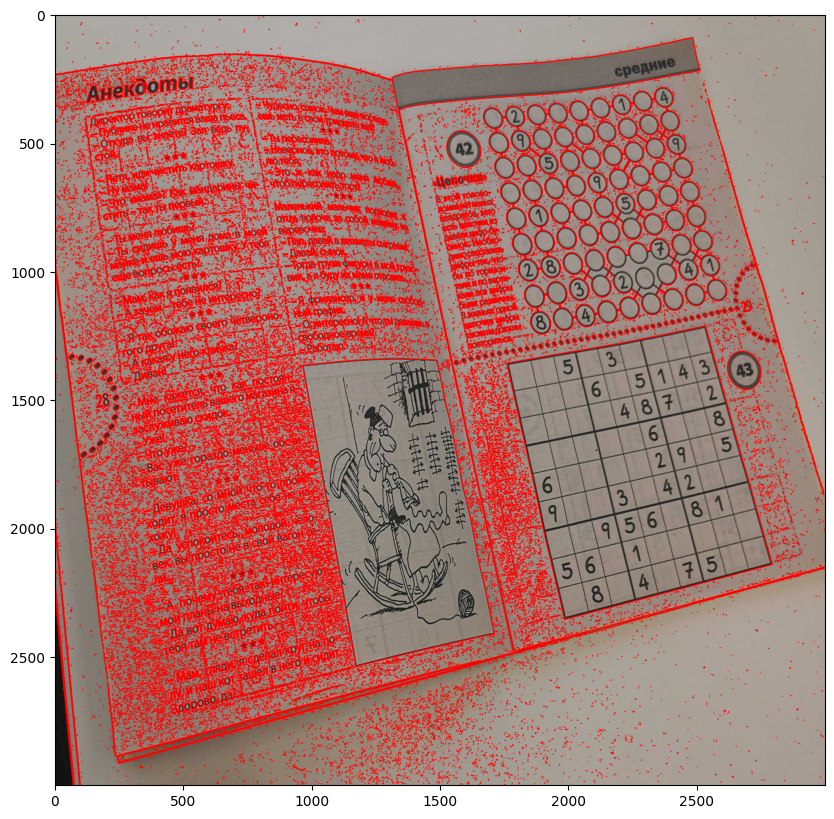

In [214]:
#All contours for an img_0
imgContours = imgBGR_copy.copy()
imgBigContours = imgBGR_copy.copy()
contours, hieracrchy = cv.findContours(imgThreshold, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(imgContours, contours, -1, (255, 0, 0), 3)
plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(imgContours)

1/1 [==============================] - 0s 34ms/step


TypeError: Invalid shape (82,) for image data

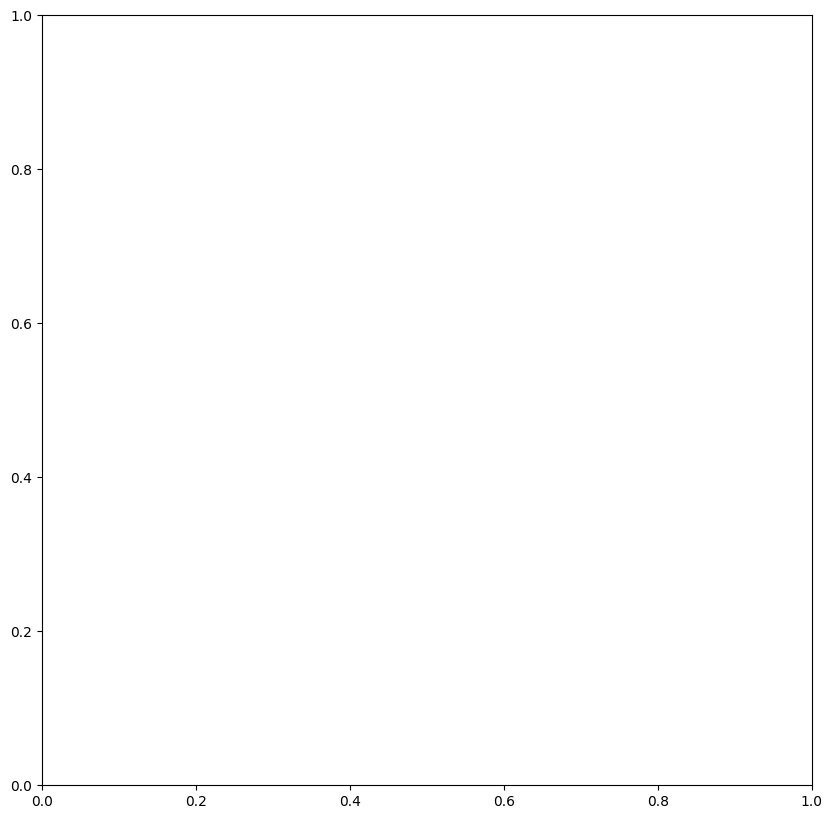

In [325]:

#Mask and Sudoku contour prediction

#Mask and Sudoku contour prediction

def mask_prediction(image):
    imgRGB = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    imgGREY = cv.cvtColor(imgRGB, cv.COLOR_RGB2GRAY)
    
    #4 th seminar has a great potential to make a nice mask to distinguish sudoku
    HLS = cv.cvtColor(imgRGB, cv.COLOR_RGB2HLS)
    LIGHT = HLS[:, :, 1]
    maskHLS = (LIGHT < 100)
    maskINT = maskHLS.astype(np.uint8)
    #Regular contour finder
    contours, useless_param = cv.findContours(maskINT, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE) 
    #array of contours
    contour_areas = [cv.contourArea(c) for c in contours] 
    #Sort values
    sort_areas_inds = sorted(range(len(contour_areas)), key=lambda k: contour_areas[k], reverse=True) 
    largest_contours=sort_areas_inds[:10]

    sudokus_contour=[]
    mask1 = np.zeros((imgGREY.shape[:2]), np.uint8)
    for i in range(len(largest_contours)):
        if (contour_areas[largest_contours[i]] > 0.5 * contour_areas[largest_contours[0]]) and (contour_areas[largest_contours[i]] > 550000) : #the second condition will find second sudoku if any
            cv.drawContours(mask1, [contours[largest_contours[i]]], 0, (255,0,0), -2) #adding largest contours
            sudokus_contour.append(contours[largest_contours[i]])
    mask = np.bool_(mask1)
    return mask, sudokus_contour

#Gives us cropped image of a sudoku
def crop(sudokus_cont, image_grey): 
    sudokus=[] 
    for i in sudokus_cont:
        epsilon = 0.1* cv.arcLength(i, True)
        approx = cv.approxPolyDP(i, epsilon, True)
        try:
            cropped_sudoku = four_point_transform(image_grey, np.ravel(approx).reshape(4,2))
        except:
            cropped_sudoku=image_grey
        sudokus.append(cropped_sudoku)
    return sudokus

#taking every single number from sudoku for further digit recognition
def get_single_cell(y,x,map):
    dx=map.shape[1]//9
    dy=map.shape[0]//9
    digit_img = map[y*dy:(y+1)*dy, x*dx:(x+1)*dx]
    return digit_img

#getting clear sudoku image
def preProcess(image): 
    pict = cv.GaussianBlur(image,(9, 9),3)
    thresh = cv.threshold(pict, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]
    imageTHRSH = clear_border(thresh)
    kernel = np.ones((3,3),np.uint8)
    erosion = cv.erode(imageTHRSH,kernel,iterations = 1)
    dilation = cv.dilate(erosion,kernel,iterations = 1)
    img_masked=dilation
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
    gray = cv.morphologyEx(dilation, cv.MORPH_OPEN, kernel)
    img_masked=gray
    return img_masked


  # process crop width and height for max available dimension
def center_crop(img, dim=(64, 64)):
    width, height = img.shape[1], img.shape[0]
    crop_width = dim[0] if dim[0] < img.shape[1] else img.shape[1]
    crop_height = dim[1] if dim[1] < img.shape[0] else img.shape[0]
    mid_point_x, mid_point_y = int(width/2), int(height/2)
    cw2, ch2 = int(crop_width/2), int(crop_height/2)
    cw2=min(cw2, ch2)
    ch2=cw2
    crop_img = img[mid_point_y - cw2:mid_point_y + cw2, mid_point_x - ch2:mid_point_x + ch2]
    return crop_img


def predict_image(image):
    model = load_model("myModel.h5")
    if (len(image.shape) == 2):
        image=cv.cvtColor(image, cv.COLOR_GRAY2BGR)
    mask=mask_prediction(image)[0]
    sudokus_contour=mask_prediction(image)[1]
    imgGREY=cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    img_array=crop(sudokus_contour, imgGREY)
    boards=[]
    for img in img_array:
        board=-np.ones((9, 9), dtype="int")
        table_img = preProcess(img)
        for y in range(0, 9):
            for x in range(0, 9):
                digit_box=get_single_cell(y,x,table_img)
                digit_box_big=center_crop(digit_box, dim=(digit_box.shape[0]-0.31*digit_box.shape[0], digit_box.shape[1]-0.31*digit_box.shape[0]))
                fillness=cv.countNonZero(digit_box_big) / float(digit_box_big.shape[0] * digit_box_big.shape[1])
                digit_box=tf.image.resize(tf.expand_dims(digit_box_big, axis=2), (28,28))
                roi = img_to_array(digit_box)
                roi = np.expand_dims(roi, axis=0)
                pred = model.predict(roi).argmax(axis=1)[0]
                if fillness<0.1:
                    pred=-1
                board[y, x] = pred
        boards.append(board)
    digits = boards
    return mask, digits, digit_box_big

a, c, digit_box = predict_image(cv.imread('train_2.jpg'))
plt.imshow(digit_box[6])
# plt.imshow(a)
# print(c)

In [215]:
#The biggest contours
'''Peri is a perimeter the total distance around the respective shape. 
For the figures with straight sides such as triangle, rectangle, 
square or a polygon; the perimeter is the sum of lengths for all the sides.'''
'''Approx allows us to figure out how many corners has a particular contour'''
def biggestContour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv.contourArea(i)
        if area > 50:
            peri = cv.arcLength(i, True)
            approx = cv.approxPolyDP(i, 0.02*peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
    return biggest, max_area
biggest, maxArea = biggestContour(contours)
print(biggest)



[[[2533 1211]]

 [[1760 1357]]

 [[1983 2354]]

 [[2794 2141]]]


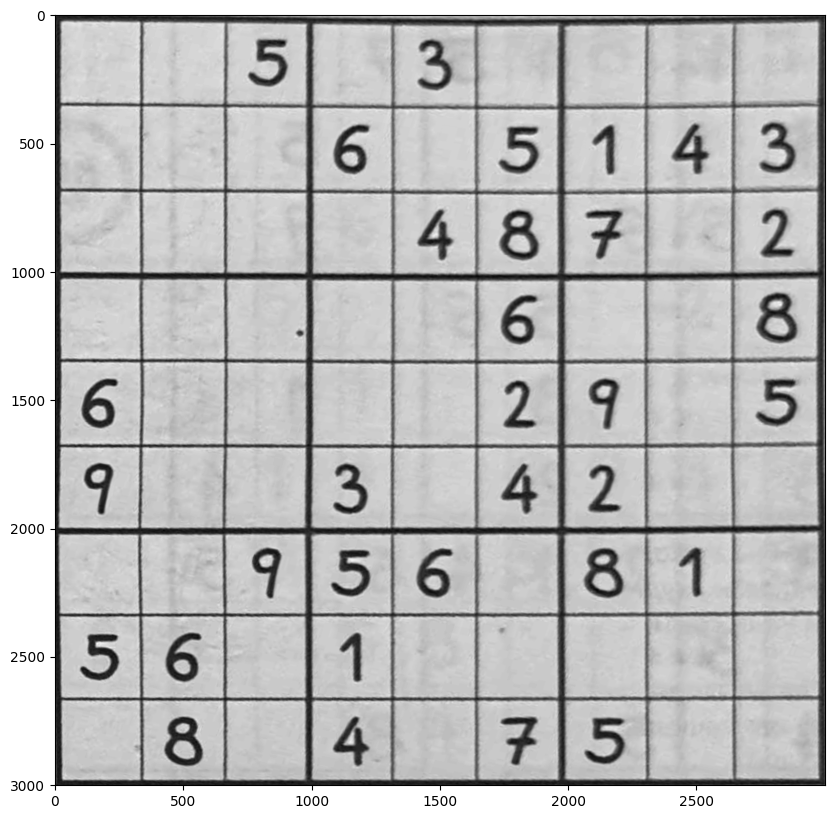

In [331]:
#Give order for dots to make them one by one on the image
def reorder(myPoints):
    myPoints = myPoints.reshape((4, 2))
    myPointsNew = np.zeros((4, 1, 2), dtype = np.int32)
    add = myPoints.sum(1)
    myPointsNew[0] = myPoints[np.argmin(add)]
    myPointsNew[3] = myPoints[np.argmax(add)]
    diff = np.diff(myPoints, axis = 1)
    myPointsNew[1] = myPoints[np.argmin(diff)]
    myPointsNew[2] = myPoints[np.argmax(diff)]
    return myPointsNew

#Instead of using exact number for width and height, i can use shape coordinates for each image
if biggest.size != 0:
    biggest = reorder(biggest)
    # print(biggest)
    cv.drawContours(imgBigContours, biggest, -1, (255, 0, 0), 25)

    pts1 = np.float32(biggest)
    pts2 = np.float32([[0, 0], [width, 0], [0, width], [width, height]])
    matrix = cv.getPerspectiveTransform(pts1, pts2)
    imgWarpColored = cv.warpPerspective(imgBGR_copy, matrix, (width, height))
    imgDetectedDigits = imgBlank.copy()
    imgWarpColored = cv.cvtColor(imgWarpColored, cv.COLOR_RGB2GRAY)
#Check the warp
plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(imgWarpColored, 'gray')

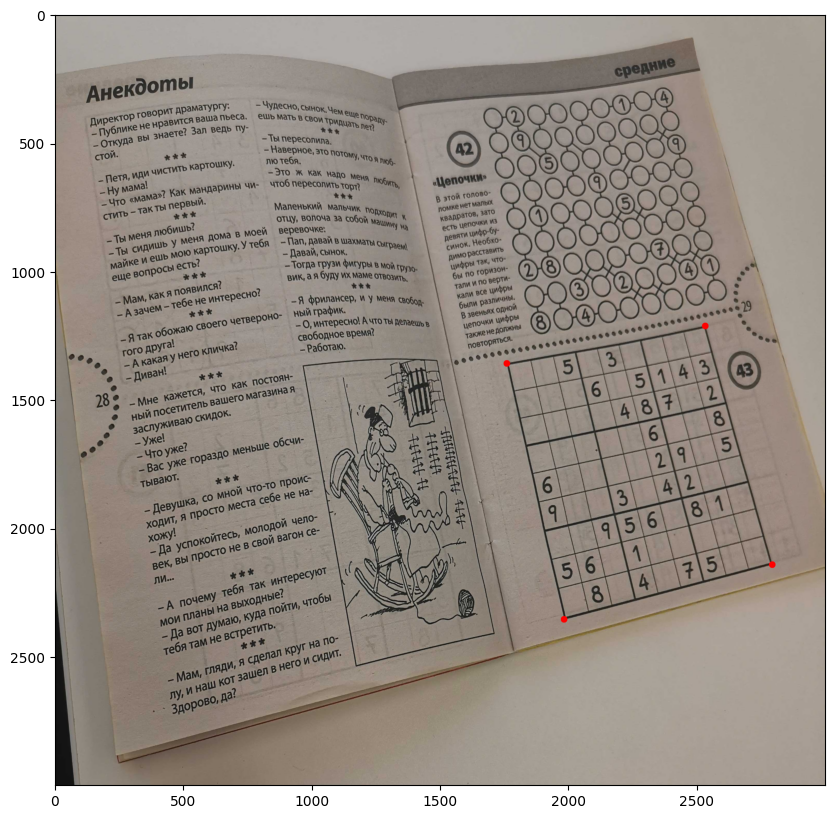

In [217]:
#check the right place for the dots
plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(imgBigContours)

In [218]:
#Split the image and find each square with some kind of symbol
imgSolvedDigits = imgBlank.copy()
imgWarpColored = cv.resize(imgWarpColored, (450,450))

print (imgWarpColored.shape)
def splitBoxes (img):
    rows = np.vsplit(img, 9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r, 9)
        for box in cols:
            boxes.append(box)
    return boxes

boxes = splitBoxes(imgWarpColored)


(450, 450)


In [267]:
def intializePredictionModel():
    model = load_model('myModel.h5')
    return model

model = intializePredictionModel()

def getPrediction (boxes, model):
    result = []
    for image in boxes:
        #Image preparation
        img = np.asarray(image)
        img = img[4:img.shape[0] - 4, 4:img.shape[1] - 4]
        img = cv.resize(img, (28,28))
        img = img / 255
        img = img.reshape(1, 28, 28, 1)
        #Predict
        predictions = model.predict(img)
        #classIndex = model.predict_classes(img)
        classIndex = np.argmax(predictions, axis = -1)
        probabilityValue = np.amax(predictions)
        #print(classIndex, probabilityValue)
        #Saving
        if probabilityValue > 0.8:
            result.append(classIndex[0])
        #elif probabilityValue < 0.2:
            #result.append(-1)   
        else:
            result.append(0)
    #result = np.array(result)
    # true_result = []
    # true_result.append(result)
    # true_result = np.array(true_result)
    boards = np.array(result)

    boards = np.reshape(boards, (9,9))
    boards[[boards == 0]] = -1 
    return boards, result




1/1 [==============================] - 0s 23ms/step
[[0 0 5 0 8 0 0 0 0]
 [0 0 0 6 0 5 1 4 8]
 [0 0 0 0 4 8 1 0 1]
 [0 0 0 0 0 6 0 0 8]
 [6 0 0 0 0 1 9 0 5]
 [9 0 0 3 0 4 1 0 0]
 [0 0 9 5 6 0 8 1 0]
 [5 6 0 1 0 0 0 0 0]
 [0 8 0 4 0 7 5 0 0]]


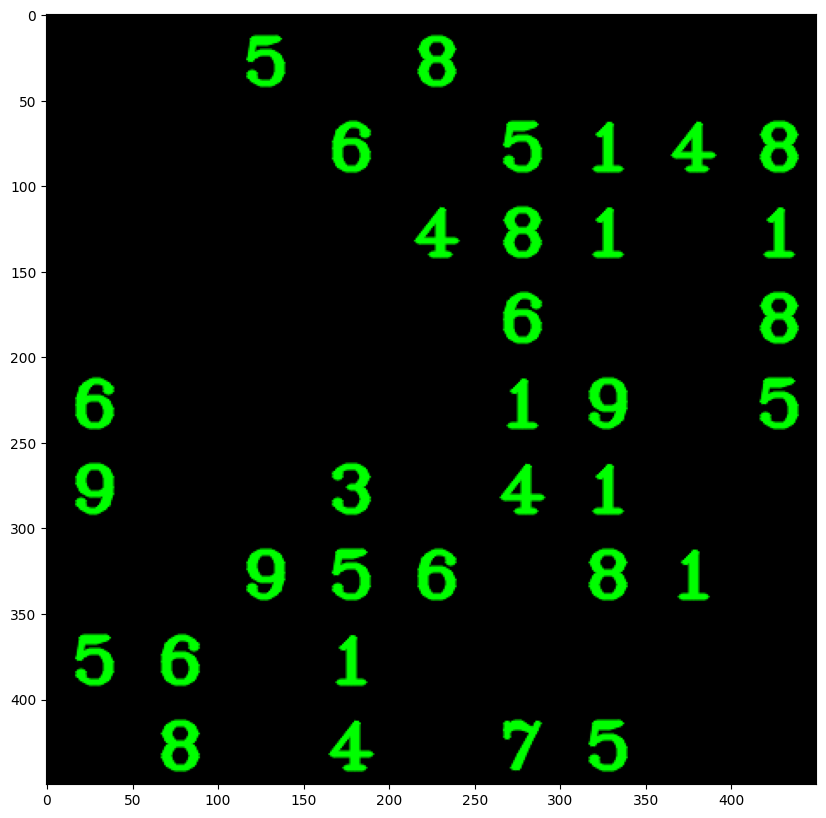

In [316]:
#Display those digits
def displayNumbers(img, numbers, color = (0, 255, 0)):
    secW = int(img.shape[1]/9)
    secH = int(img.shape[0]/9)
    for x in range (0,9):
        for y in range (0,9):
            if numbers[(y*9) + x] != 0:
                cv.putText(img, str(numbers[(y*9) + x]),
                (x*secW+int(secW/2) - 10, int((y + 0.8)*secH)), cv.FONT_HERSHEY_COMPLEX_SMALL, 2 , color, 2, cv.LINE_AA)
    return img

imgDetectedDigits = displayNumbers(imgDetectedDigits, numbers, color=(0, 255, 0))
plt.imshow(imgDetectedDigits)

In [271]:
numbers = np.asarray(numbers)
posArray = np.where(numbers > 0, 0, 1)
board = np.array_split(numbers, 9)
print(board)

[array([0, 0, 5, 0, 8, 0, 0, 0, 0], dtype=int64), array([0, 0, 0, 6, 0, 5, 1, 4, 8], dtype=int64), array([0, 0, 0, 0, 4, 8, 1, 0, 1], dtype=int64), array([0, 0, 0, 0, 0, 6, 0, 0, 8], dtype=int64), array([6, 0, 0, 0, 0, 1, 9, 0, 5], dtype=int64), array([9, 0, 0, 3, 0, 4, 1, 0, 0], dtype=int64), array([0, 0, 9, 5, 6, 0, 8, 1, 0], dtype=int64), array([5, 6, 0, 1, 0, 0, 0, 0, 0], dtype=int64), array([0, 8, 0, 4, 0, 7, 5, 0, 0], dtype=int64)]


In [ ]:
#Trying to find the solution
board = np.array_split(numbers, 9)

try:
    sudokuSolver.solve(board)

# ALTERNATIVE SOLUTION


[array([[[2508, 1016]],

       [[2507, 1017]],

       [[2502, 1017]],

       ...,

       [[2514, 1020]],

       [[2514, 1017]],

       [[2513, 1016]]], dtype=int32)]


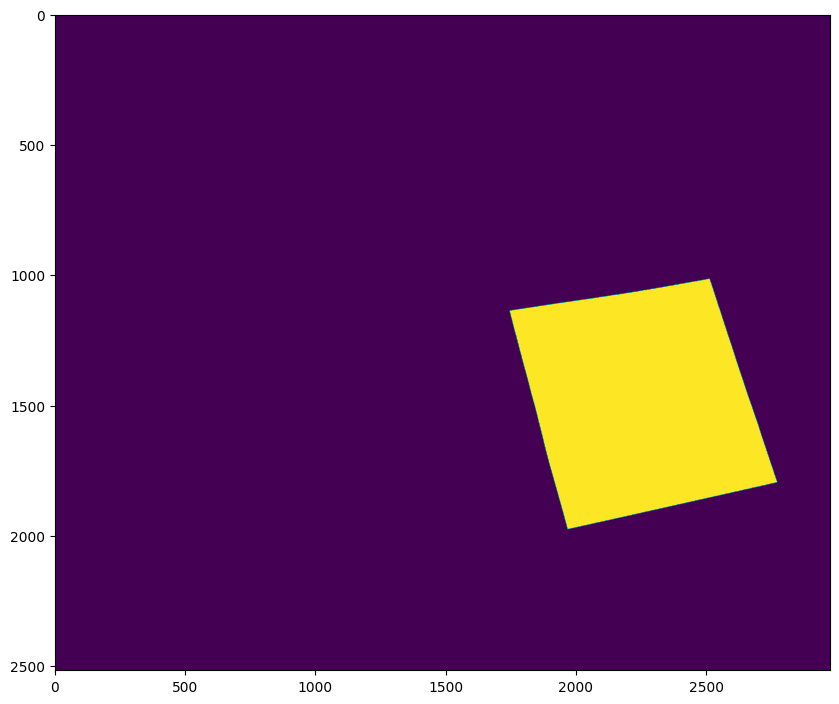

In [311]:
def predict_mask(image):
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sudoku_digits = [
        np.int16([[-1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [-1, -1, -1,  8,  9,  4, -1, -1, -1],
                  [-1, -1, -1,  6, -1,  1, -1, -1, -1],
                  [-1,  6,  5,  1, -1,  9,  7,  8, -1],
                  [-1,  1, -1, -1, -1, -1, -1,  3, -1],
                  [-1,  3,  9,  4, -1,  5,  6,  1, -1],
                  [-1, -1, -1,  8, -1,  2, -1, -1, -1],
                  [-1, -1, -1,  9,  1,  3, -1, -1, -1],
                  [-1, -1, -1, -1, -1, -1, -1, -1, -1]]),
    ]
    img = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    img_grey = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    
    #let's use hsl representation, cause light can help to properly distinguish between black ans white
    HLS = cv.cvtColor(img, cv.COLOR_RGB2HLS)
    LIGHT = HLS[:, :, 1]

    mask_hls = (LIGHT < 100)
    mask_int = mask_hls.astype(np.uint8)

    contours, useless_param = cv.findContours(mask_int, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE) #find contours in the picture

    areas = [cv.contourArea(c) for c in contours] #let's make array of areas of contours

    sort_areas_inds= sorted(range(len(areas)), key=lambda k: areas[k], reverse=True) #from largest to smallest
    largest=sort_areas_inds[:10]
    
    sudokus_cont=[]
    mask1 = np.zeros((img_grey.shape[:2]), np.uint8)
    for i in range(len(largest)):
        if (areas[largest[i]] > 0.5 * areas[largest[0]]) and (areas[largest[i]]>550000) : #this condition helps to find second sudoku
            cv.drawContours(mask1,[contours[largest[i]]], 0, (255,0,0), -2) #adding largest contours
            sudokus_cont.append(contours[largest[i]])
    mask = np.bool_(mask1)

    return mask, sudokus_cont

mask, sudokus_cont = predict_mask(imgBGR)

plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(mask)
print(sudokus_cont)

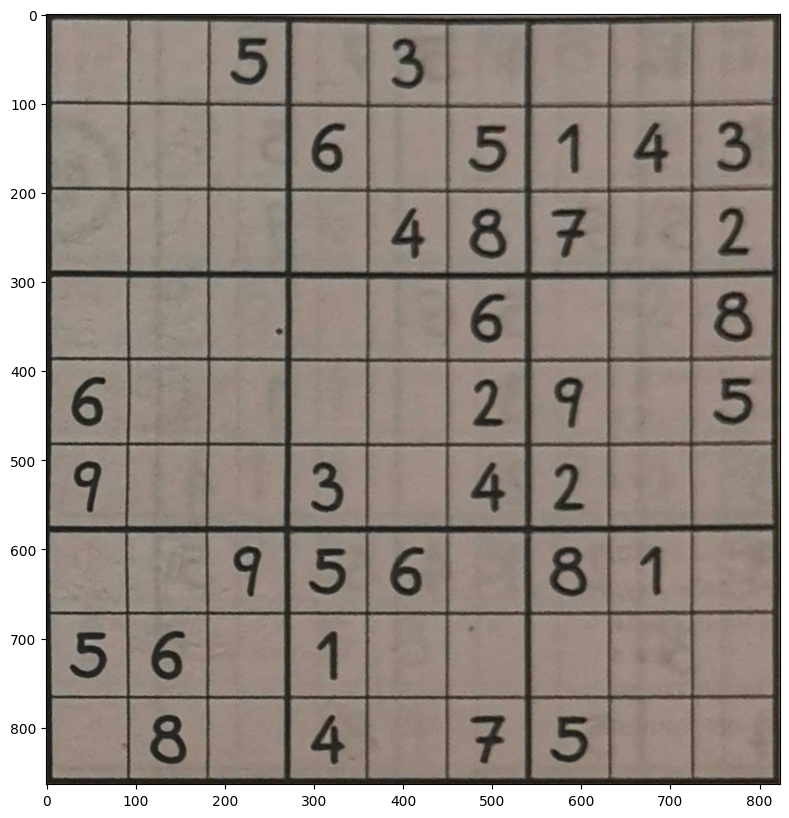

In [143]:
def get_cropped(sudokus_cont, image_grey): #returns arrray of sudoku fields from image
    sudokus=[] #list of images corresponding to cropped sudokus
    for i in sudokus_cont:
        #print(i)
        epsilon = 0.1* cv.arcLength(i, True)
        approx = cv.approxPolyDP(i, epsilon, True)
        #print(approx)
        #print(np.ravel(approx).shape)
        #print(type(approx))
        cropped_sudoku= four_point_transform(image_grey, np.ravel(approx).reshape(4,2))
        sudokus.append(cropped_sudoku)

    #for imgs in sudokus:
        #plt.imshow(imgs)
    return sudokus

sudokus = get_cropped(sudokus_cont, imgBGR)

plt.rcParams["figure.figsize"] = (10,10)
plt.imshow(sudokus[0])
# print(sudokus_cont)


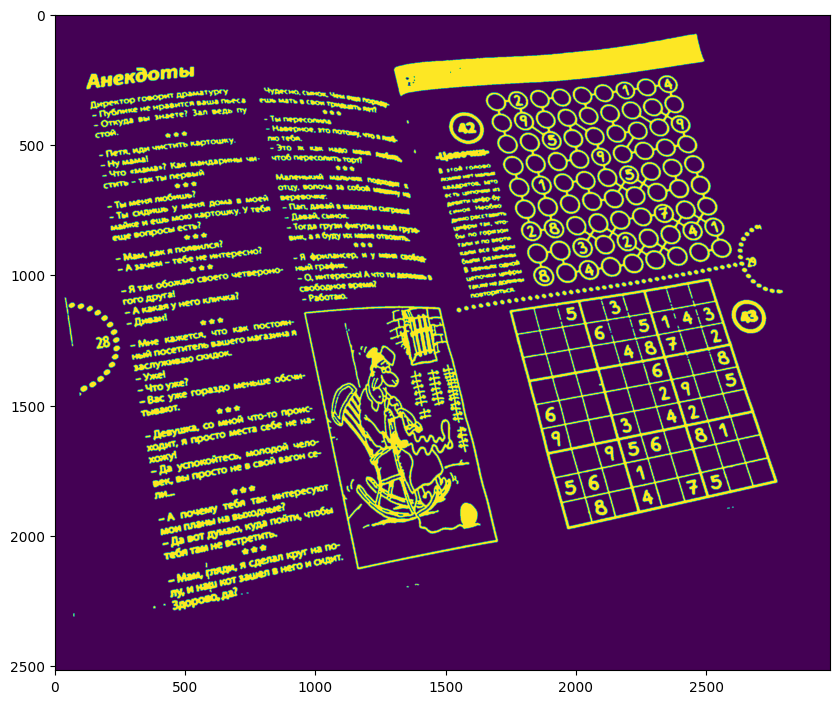

In [147]:
def preprocessing(image): #the images are grey
        #print(image.shape)
        #img_grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        #let's use hsl representation, cause light can help to properly distinguish between black ans white

        pict = cv.GaussianBlur(image,(9, 9),3)
        thresh = cv.threshold(pict, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]
        th_image = clear_border(thresh)
        mask = np.zeros(th_image.shape, dtype = "uint8")
        digit = cv.bitwise_not(th_image)
        pict=th_image
        #pict = cv2.GaussianBlur(pict,(9, 9),3)
        kernel = np.ones((3,3),np.uint8)
        erosion = cv.erode(pict,kernel,iterations = 1)
        dilation = cv.dilate(erosion,kernel,iterations = 1)
        img_masked=dilation
        kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
        gray = cv.morphologyEx(dilation, cv.MORPH_OPEN, kernel)
        img_masked=gray
        #LIGHT=gray
        #mask_hls = (LIGHT < 100)|(LIGHT > 250)
        #mask_int = mask_hls.astype(np.uint8)
        #img_masked=mask_int
        #img_masked = 255*(LIGHT < 100)  # img_masked = 1-(LIGHT < 100) in case you want black numbers on white
        #print(image2.shape)
        #thresh = cv2.threshold(img_masked, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        #thresh = clear_border(thresh)
        return img_masked
        
plt.imshow(preprocessing(imgGRAY))

In [149]:
def get_item(y,x,map):
    dx=map.shape[1]//9
    dy=map.shape[0]//9
    digit_img = map[y*dy:(y+1)*dy, x*dx:(x+1)*dx]
    return digit_img

In [150]:
def center_crop(img, dim=(64, 64)):
    """Returns center cropped image
    Args:
    img: image to be center cropped
    dim: dimensions (width, height) to be cropped
    """
    width, height = img.shape[1], img.shape[0]

    # process crop width and height for max available dimension
    crop_width = dim[0] if dim[0]<img.shape[1] else img.shape[1]
    crop_height = dim[1] if dim[1]<img.shape[0] else img.shape[0] 
    mid_x, mid_y = int(width/2), int(height/2)
    cw2, ch2 = int(crop_width/2), int(crop_height/2) 
    cw2=min(cw2, ch2)
    ch2=cw2
    crop_img = img[mid_y-cw2:mid_y+cw2, mid_x-ch2:mid_x+ch2]
    return crop_img

In [379]:
import numpy as np
import matplotlib.pyplot as plt
import operator
import joblib
import random
from sklearn.ensemble import RandomForestClassifier
def predict_image(image):
    model = load_model('model/cnn_classifier_custom.h5')
    if (len(image.shape)==2):
        image=cv.cvtColor(image, cv.COLOR_GRAY2BGR)
    #image=cv2.imread('train_0.jpg')
    mask=predict_mask(image)[0]
    sudokus_cont=predict_mask(image)[1]
    #print(sudokus_cont)
    image_grey=cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    #if (len(image.shape)==2):
        #image_grey=image
    #for cont in sudokus_cont:
    img_array=get_cropped(sudokus_cont, image_grey)
    boards=[]
    #print(len(img_array))
    for img in img_array:
        board=-np.ones((9, 9), dtype="int")
        table_img = preprocessing(img)
        #plt.imshow(table)
        #print(table.shape)
        for y in range(0, 9):
            for x in range(0, 9):
                digit_im=get_item(y,x,table_img)
                digit_img_big=center_crop(digit_im, dim=(digit_im.shape[0]-0.1*digit_im.shape[0], digit_im.shape[1]-0.1*digit_im.shape[0]))
                fillness=cv.countNonZero(digit_img_big) / float(digit_img_big.shape[0] * digit_img_big.shape[1])
                #print(digit_img_big.shape)
                digit_img=tf.image.resize(tf.expand_dims(digit_img_big, axis=2), (28,28))
                roi = img_to_array(digit_img)
                roi = np.expand_dims(roi, axis=0)
                pred = model.predict(roi).argmax(axis=1)[0]
                if fillness<0.05:
                    pred=-1
                board[y, x] = pred
        boards.append(board)

    return mask, boards
#cv2.imread('train_1.jpg')
mask, boards = predict_image(cv.imread('train_1.jpg'))

print(boards)

AttributeError: 'NoneType' object has no attribute 'shape'

1/1 [==============================] - 0s 23ms/step
[array([[-1, -1, -1, -1, -1,  6, -1, -1, -1],
       [-1, -1, -1,  3,  4, -1, -1, -1,  8],
       [ 9,  3, -1, -1,  7, -1, -1,  4,  1],
       [ 3, -1, -1,  4, -1, -1, -1, -1,  1],
       [ 5,  7, -1, -1,  6, -1, -1, -1, -1],
       [-1,  4, -1,  7,  8, -1,  6,  9,  5],
       [ 4, -1, -1, -1,  1, -1, -1,  5,  9],
       [-1, -1, -1, -1, -1, -1, -1,  1,  6],
       [-1, -1, -1, -1, -1,  9,  4,  6,  3]], dtype=int16)]
[array([[-1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1,  8,  9,  4, -1, -1, -1],
       [-1, -1, -1,  6, -1,  1, -1, -1, -1],
       [-1,  6,  5,  1, -1,  9,  7,  8, -1],
       [-1,  1, -1, -1, -1, -1, -1,  3, -1],
       [-1,  3,  9,  4, -1,  5,  6,  1, -1],
       [-1, -1, -1,  8, -1,  2, -1, -1, -1],
       [-1, -1, -1,  9,  1,  3, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1]], dtype=int16)]


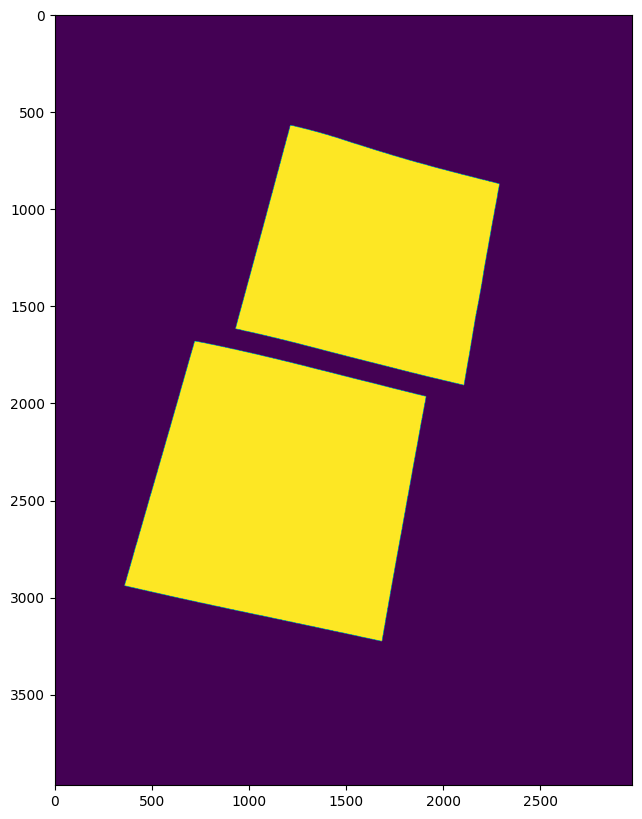

In [288]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
import operator
from skimage.segmentation import clear_border
import torch
import math
from imutils.perspective import four_point_transform
from tensorflow.keras.models import load_model

'''We are getting numbers in this chank of code'''

#Getting threshold
def predict_mask(image):
    #image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    # img = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    img_grey = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    #mask = np.zeros((img_grey.shape[:2]), np.uint8)
    #let's use hsl representation, cause light can help to properly distinguish between black ans white
    HLS = cv.cvtColor(image, cv.COLOR_RGB2HLS)
    LIGHT = HLS[:, :, 1]

    mask_hls = (LIGHT < 100)
    mask_int = mask_hls.astype(np.uint8)

    contours, hierarchy = cv.findContours(mask_int, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE) #find contours in the picture

    areas = [cv.contourArea(c) for c in contours] #let's make array of areas of contours

    sort_areas_inds= sorted(range(len(areas)), key=lambda k: areas[k], reverse=True) #from largest to smallest
    largest=sort_areas_inds[:10]
    
    sudokus_cont=[]
    mask1 = np.zeros((img_grey.shape[:2]), np.uint8)
    for i in range(len(largest)):
        if (areas[largest[i]] > 0.5 * areas[largest[0]])and(areas[largest[i]]>550000) : #this condition helps to find second sudoku
            cv.drawContours(mask1,[contours[largest[i]]], 0, 1, -1) #adding largest contours
            sudokus_cont.append(contours[largest[i]])
    mask = np.bool_(mask1)
    # loading train image:
    #train_img_4 = cv.imread('/autograder/source/train/train_4.jpg', 0)

    # loading model:  (you can use any other pickle-like format)
    #rf = joblib.load('/autograder/submission/random_forest.joblib')
    return mask, sudokus_cont, img_grey

def get_cropped(sudokus_cont, image_grey): #returns arrray of sudoku fields from image

    sudokus=[] #list of images corresponding to cropped sudokus
    for i in sudokus_cont:
        #print(i)
        epsilon = 0.1* cv.arcLength(i, True)
        approx = cv.approxPolyDP(i, epsilon, True)
        #print(approx)
        #print(np.ravel(approx).shape)
        #print(type(approx))
        cropped_sudoku= four_point_transform(image_grey, np.ravel(approx).reshape(4,2))
        sudokus.append(cropped_sudoku)
    return sudokus

def splitBoxes (img):
    for pieces in img:
        pieces = cv.resize(pieces, (450,450))
        rows = np.vsplit(pieces, 9)
        boxes = []
        for r in rows:
            cols = np.hsplit(r, 9)
            for box in cols:
                boxes.append(box)
    return boxes

def intializePredictionModel():
    model = load_model('myModel.h5')
    return model


def getPrediction (boxes):
    model = intializePredictionModel()
    result = []
    for image in boxes:
        #Image preparation
        img = np.asarray(image)
        img = img[4:img.shape[0] - 4, 4:img.shape[1] - 4]
        img = cv.resize(img, (28,28))
        img = img / 255
        img = img.reshape(1, 28, 28, 1)
        #Predict
        predictions = model.predict(img)
        #classIndex = model.predict_classes(img)
        classIndex = np.argmax(predictions, axis = -1)
        probabilityValue = np.amax(predictions)
        #print(classIndex, probabilityValue)
        #Saving
        if probabilityValue > 0.8:
            result.append(classIndex[0])
        else:
            result.append(-1)
    boards = np.array(result)
    boards = np.reshape(boards, (9,9))
    boards =[np.int16(boards)]
    return boards, result

def predict_image(img):
    mask, sudokus_cont, img_grey = predict_mask(img)
    sudokus = get_cropped(sudokus_cont, img_grey)
    boxes = splitBoxes (sudokus)
    digits, result = getPrediction (boxes)
    return mask, digits

img2 = cv.imread('train_2.jpg')
mask, digits = predict_image(img2)

plt.imshow(mask)

print(digits)
sudoku_digits = [
        np.int16([[-1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [-1, -1, -1,  8,  9,  4, -1, -1, -1],
                  [-1, -1, -1,  6, -1,  1, -1, -1, -1],
                  [-1,  6,  5,  1, -1,  9,  7,  8, -1],
                  [-1,  1, -1, -1, -1, -1, -1,  3, -1],
                  [-1,  3,  9,  4, -1,  5,  6,  1, -1],
                  [-1, -1, -1,  8, -1,  2, -1, -1, -1],
                  [-1, -1, -1,  9,  1,  3, -1, -1, -1],
                  [-1, -1, -1, -1, -1, -1, -1, -1, -1]]),
    ]
print(sudoku_digits)

In [386]:
from skimage.feature import canny
from skimage.transform import rescale, ProjectiveTransform, warp
from skimage.morphology import dilation, disk
import cv2 as cv
import numpy as np
from imutils.perspective import four_point_transform
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
import imutils
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from skimage.segmentation import clear_border
import joblib

"""Huge part pf the mask prediction is got from stackoverflow"""
#Mask and Sudoku contour prediction

def mask_prediction(image):

    imgRGB = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    imgGREY = cv.cvtColor(imgRGB, cv.COLOR_RGB2GRAY)
    
    #4 th seminar has a great potential to make a nice mask to distinguish sudoku
    HLS = cv.cvtColor(imgRGB, cv.COLOR_RGB2HLS)
    LIGHT = HLS[:, :, 1]
    maskHLS = (LIGHT < 100)
    maskINT = maskHLS.astype(np.uint8)
    #Regular contour finder
    contours, useless_param = cv.findContours(maskINT, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE) 
    #array of contours
    contour_areas = [cv.contourArea(c) for c in contours] 
    #Sort values
    sort_areas_inds = sorted(range(len(contour_areas)), key=lambda k: contour_areas[k], reverse=True) 
    largest_contours=sort_areas_inds[:10]

    sudokus_contour=[]
    mask1 = np.zeros((imgGREY.shape[:2]), np.uint8)
    for i in range(len(largest_contours)):
        if (contour_areas[largest_contours[i]] > 0.5 * contour_areas[largest_contours[0]]) and (contour_areas[largest_contours[i]] > 550000) : #the second condition will find second sudoku if any
            cv.drawContours(mask1, [contours[largest_contours[i]]], 0, (255,0,0), -2) #adding largest contours
            sudokus_contour.append(contours[largest_contours[i]])
    mask = np.bool_(mask1)
    return mask, sudokus_contour

#Got the thing with four point transform from Data science friends
#Gives us cropped image of a sudoku
def crop(sudokus_cont, image_grey): 
    sudokus=[] 
    for i in sudokus_cont:
        epsilon = 0.1* cv.arcLength(i, True)
        approx = cv.approxPolyDP(i, epsilon, True)
        try:
            cropped_sudoku = four_point_transform(image_grey, np.ravel(approx).reshape(4,2))
        except:
            cropped_sudoku=image_grey
        sudokus.append(cropped_sudoku)
    return sudokus

#taking every single number from sudoku for further digit recognition
def get_single_cell(y,x,map):
    dx=map.shape[1]//9
    dy=map.shape[0]//9
    digit_img = map[y*dy:(y+1)*dy, x*dx:(x+1)*dx]
    return digit_img

#getting clear sudoku image
def preProcess(image): 
    pict = cv.GaussianBlur(image,(9, 9),3)
    thresh = cv.threshold(pict, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]
    imageTHRSH = clear_border(thresh)
    kernel = np.ones((3,3),np.uint8)
    erosion = cv.erode(imageTHRSH,kernel,iterations = 1)
    dilation = cv.dilate(erosion,kernel,iterations = 1)
    img_masked=dilation
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
    gray = cv.morphologyEx(dilation, cv.MORPH_OPEN, kernel)
    img_masked=gray
    return img_masked


  # process crop width and height for max available dimension
def center_crop(img, dim=(64, 64)):
    width, height = img.shape[1], img.shape[0]
    crop_width = dim[0] if dim[0] < img.shape[1] else img.shape[1]
    crop_height = dim[1] if dim[1] < img.shape[0] else img.shape[0]
    mid_point_x, mid_point_y = int(width/2), int(height/2)
    cw2, ch2 = int(crop_width/2), int(crop_height/2)
    cw2=min(cw2, ch2)
    ch2=cw2
    crop_img = img[mid_point_y - cw2:mid_point_y + cw2, mid_point_x - ch2:mid_point_x + ch2]
    return crop_img

'''Model has been raking and over thought from three different sources:
https://pyimagesearch.com/2020/08/10/opencv-sudoku-solver-and-ocr/
https://towardsdatascience.com/open-cv-based-sudoku-solver-powered-by-rust-df256653d5b3
https://gist.github.com/qgolsteyn/7da376ced650a2894c2432b131485f5d'''
def predict_image(image):
    model = joblib.load('model/clf.joblib')
    if (len(image.shape) == 2):
        image=cv.cvtColor(image, cv.COLOR_GRAY2BGR)
    sudokus_contour=mask_prediction(image)[1]
    imgGREY=cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    img_array=crop(sudokus_contour, imgGREY)
    boards=[]
    for img in img_array:
        board=-np.ones((9, 9), dtype="float")
        table_img = preProcess(img)
        for y in range(0, 9):
            for x in range(0, 9):
                digit_box=get_single_cell(y,x,table_img)
                digit_box_big=center_crop(digit_box, dim=(digit_box.shape[0]-0.31*digit_box.shape[0], digit_box.shape[1]-0.31*digit_box.shape[0]))
                fillness=cv.countNonZero(digit_box_big) / float(digit_box_big.shape[0] * digit_box_big.shape[1])
                digit_box=tf.image.resize(tf.expand_dims(digit_box_big, axis=2), (28,28))
                ita = img_to_array(digit_box)
                ita = np.expand_dims(ita, axis=0)
                pred = model.predict(ita).argmax(axis=1)[0]
                if fillness<0.1:
                    pred=-1
                board[y, x] = pred
        boards.append(board)
    digits = boards
    mask=mask_prediction(image)[0]
    return mask, digits

a, b = predict_image(cv.imread('train/train_0.jpg'))
print(b)


c:\Users\danii\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.1 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\danii\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.1 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ValueError: Found array with dim 4. RandomForestClassifier expected <= 2.

In [363]:
from itertools import islice
from typing import Iterable, Union, Tuple

import numpy as np


def solve(field: Union[str, np.ndarray, list, tuple], cell_shape: Tuple[int, int] = None) -> Iterable[np.ndarray]:
    """
    Solves a sudoku puzzle and yields all possible solutions.
    Parameters
    ----------
    field
        if array - nan values denote unfilled positions, if str - '?' denotes unfilled positions
    cell_shape
        the shape of a single cell (e.g. simple sudoku = (3, 3) ), supports non-square cells.
        if None - the shape is considered square and is inferred from field's shape
    """
    if isinstance(field, str):
        field, initial, cell_shape = parse_text(field, cell_shape)
    else:
        field, initial, cell_shape = parse_array(field, cell_shape)

    for v in initial:
        propagate_constraints(field, *v, cell_shape)
    return make_suggestions(field, cell_shape)


class NotSolvable(ValueError):
    pass


def propagate_constraints(field, i, j, value, cell_shape):
    mask = field[..., value]
    update_at = np.zeros_like(mask)

    # rows, cols
    update_at[i] = 1
    update_at[:, j] = 1

    # cell
    start = (np.array((i, j)) // cell_shape) * cell_shape
    stop = start + cell_shape
    update_at[tuple(map(slice, start, stop))] = 1

    # except
    update_at[i, j] = 0

    # only where should remove
    update_at = update_at & mask
    mask[update_at] = 0

    if not field.any(-1).all():
        # no possible values
        raise NotSolvable

    # propagate
    update_at = update_at & (field.sum(-1) == 1)
    xs, ys = np.where(update_at)
    for i, j in zip(xs, ys):
        unique_value, = np.where(field[i, j])[0]
        propagate_constraints(field, i, j, unique_value, cell_shape)


def is_solved(field):
    return (field.sum(-1) == 1).all()


def make_suggestions(field, cell_shape):
    if is_solved(field):
        values = np.where(field)[2] + 1
        yield values.reshape(*field.shape[:2])
        return

    variants = field.sum(-1).astype(float)
    variants[variants == 1] = np.inf
    idx = np.argmin(variants)
    i, j = np.unravel_index(idx, field.shape[:2])

    for value in range(len(field)):
        if field[i, j, value]:
            suggestion = field.copy()
            # suppose that the real value at (i,j) is `value`
            suggestion[i, j] = 0
            suggestion[i, j, value] = 1

            try:
                propagate_constraints(suggestion, i, j, value, cell_shape)
                yield from make_suggestions(suggestion, cell_shape)
            except NotSolvable:
                pass


def get_cell_shape(field_side, cell_shape):
    if cell_shape is None:
        cell_side = int(np.sqrt(field_side))
        assert cell_side ** 2 == field_side
        cell_shape = np.array((cell_side, cell_side), int)

    cell_size = np.prod(cell_shape)
    assert field_side == cell_size
    return cell_shape, cell_size


def parse_text(text: str, cell_shape):
    values = text.split()
    field_side = int(np.sqrt(len(values)))
    if len(values) != field_side ** 2:
        raise ValueError('The field is not square.')

    cell_shape, cell_size = get_cell_shape(field_side, cell_shape)
    field = np.ones([field_side] * 3, dtype=bool)

    initial = []
    for i, value in enumerate(values):
        if value != '?':
            value = int(value)
            assert 0 < value <= cell_size, value

            i, j = np.unravel_index(i, field.shape[:2])
            value -= 1
            field[i, j] = 0
            field[i, j, value] = 1
            initial.append((i, j, value))

    return field, initial, cell_shape


def parse_array(array: np.ndarray, cell_shape):
    array = np.asarray(array, float)
    field_side = len(array)
    if array.ndim != 2 or field_side != array.shape[1]:
        raise ValueError('The field is not square.')

    cell_shape, cell_size = get_cell_shape(field_side, cell_shape)
    field = np.ones([field_side] * 3, dtype=bool)
    not_empty = ~np.isnan(array)

    initial = []
    for i, j in zip(*not_empty.nonzero()):
        value = int(array[i, j])
        assert 0 < value <= cell_size

        value -= 1
        field[i, j] = 0
        field[i, j, value] = 1
        initial.append((i, j, value))

    return field, initial, cell_shape


def print_field(field: np.ndarray, cell_shape: Tuple[int, int] = None):
    cell_shape, cell_size = get_cell_shape(len(field), cell_shape)
    h, w = cell_shape
    number_width = int(np.log10(cell_size - 1)) + 1
    result_width = cell_size * (number_width + 1) + 2 * cell_size // w + 1

    for i, row in enumerate(field):
        if i % h == 0:
            print('-' * result_width)

        for j, value in enumerate(row):
            value = str(value).ljust(number_width + 1, ' ')

            if j % w == 0:
                print('| ', end='')
            print(value, end='')
        print('|')
    print('-' * result_width)


def print_solutions(text: str, cell_shape: Tuple[int, int] = None, max_solutions: int = None):
    solutions = solve(text, cell_shape)
    if max_solutions is not None:
        solutions = islice(solutions, max_solutions)

    for solution in solutions:
        print_field(solution, cell_shape)
        print()

In [367]:
r = next(solve(b[0]))

NotSolvable: 

In [361]:
r

array([[8, 3, 9, 1, 4, 2, 5, 6, 7],
       [1, 2, 7, 6, 8, 5, 3, 4, 9],
       [5, 4, 6, 3, 9, 7, 2, 8, 1],
       [4, 6, 8, 5, 1, 3, 7, 9, 2],
       [9, 1, 3, 7, 2, 8, 4, 5, 6],
       [2, 7, 5, 4, 6, 9, 1, 3, 8],
       [7, 9, 1, 8, 3, 4, 6, 2, 5],
       [6, 8, 4, 2, 5, 1, 9, 7, 3],
       [3, 5, 2, 9, 7, 6, 8, 1, 4]], dtype=int64)